In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.ticker import MultipleLocator

%matplotlib inline

from pathlib import Path

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from src.data.data_loader_pooch import *
from src.data.fars_utils import createPerID, getWeightedAvg, standard_error

from tqdm.notebook import tqdm

pd.set_option('precision', 3)
pd.set_option('display.max_columns', 999)


In [3]:
plt.style.use(['ircobi'])

In [4]:
vehicles, accidents, people = load_pipeline(1975, 2018, first_run=False, target_folder="full")

Loading mappings...
Mappings loaded.
Loading data...
Done


## Show total number of crashes per year

In [5]:
crashes_per_year = accidents['YEAR'].value_counts()

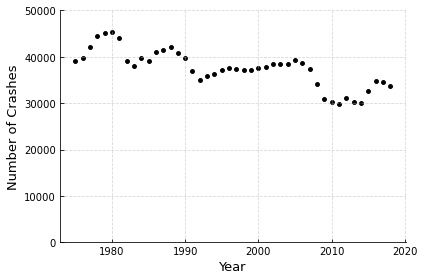

In [6]:
fig, ax = plt.subplots()

plt.scatter(crashes_per_year.index, crashes_per_year.values,
            s=15, c='black')
ax.set_ylabel('Number of Crashes', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylim(0,50000)

fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "crashes_per_year.png", dpi=360)
plt.show()

## Show total number of fatalities per year

In [6]:
inj_sev_per_year = people.groupby(['YEAR'])['INJ_SEV'].value_counts()
fatals_per_year = inj_sev_per_year.xs('Fatal Injury (K)', level='INJ_SEV')

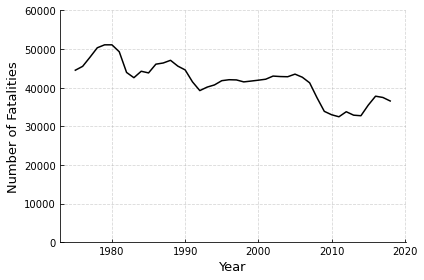

In [217]:
fig, ax = plt.subplots()

plt.plot(fatals_per_year.index, fatals_per_year.values,
         marker='', ms=5, ls='-', c='black')
ax.set_ylabel('Number of Fatalities', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylim(0,60000)
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatalities_per_year.png", dpi=360)
plt.show()

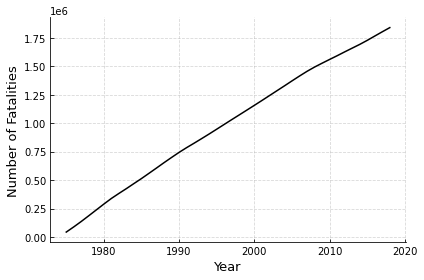

In [216]:
fig, ax = plt.subplots()

plt.plot(fatals_per_year.index, fatals_per_year.cumsum().values,
         marker='', ms=5, ls='-', c='black')
ax.set_ylabel('Number of Fatalities', fontsize=13)
ax.set_xlabel('Year', fontsize=13)

fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatalities_per_year_cum.png", dpi=360)
plt.show()

## Show total number of fatalities, male vs female

In [7]:
inj_sev_per_year = people.groupby(['YEAR', 'SEX'])['INJ_SEV'].value_counts()
fatals_by_sex = inj_sev_per_year.xs('Fatal Injury (K)', level='INJ_SEV')

In [8]:
male_fatals = fatals_by_sex.xs('Male', level='SEX')
female_fatals = fatals_by_sex.xs('Female', level='SEX')

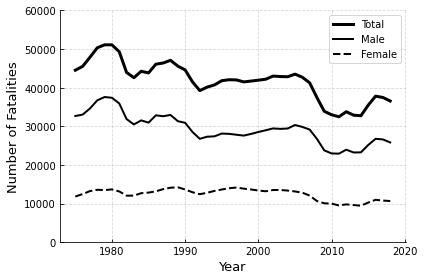

In [11]:
fig, ax = plt.subplots()
plt.plot(fatals_per_year.index, fatals_per_year.values,
         marker='', ms=5, ls='-', c='black', 
         lw=3, label='Total')
plt.plot(male_fatals.index, male_fatals.values,
         marker='', ms=5, ls='-', c='black',
         lw=2, label='Male')
plt.plot(female_fatals.index, female_fatals.values,
         marker='', ms=5, ls='--', c='black',
         lw=2, label='Female')
ax.set_ylabel('Number of Fatalities', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylim(0,60000)

ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatals_by_sex.png", dpi=360)
plt.show()

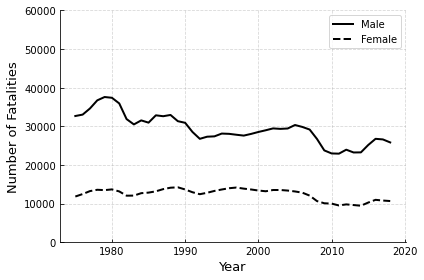

In [12]:
fig, ax = plt.subplots()

plt.plot(male_fatals.index, male_fatals.values,
         marker='', ms=5, ls='-', c='black',
         lw=2, label='Male')
plt.plot(female_fatals.index, female_fatals.values,
         marker='', ms=5, ls='--', c='black',
         lw=2, label='Female')
ax.set_ylabel('Number of Fatalities', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylim(0,60000)
ax.grid(linestyle='--', alpha=.5)
ax.tick_params(direction='in')

ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatals_by_sex_no_total.png", dpi=360)
plt.show()

## Show total number of fatalities, by model year

In [192]:
people_plus_mod_year = pd.merge(people, vehicles[['YEAR', 'ST_CASE', 'MOD_YEAR', 'VEH_NO']],
                                    on=['YEAR', 'ST_CASE', 'VEH_NO'], how='left', validate='m:1')
people_plus_mod_year_10 = people_plus_mod_year.query('(1950 < MOD_YEAR < 3000) and ((MOD_YEAR+10) >= YEAR) and (MOD_YEAR <= (YEAR+2))')
people_plus_mod_year_5 = people_plus_mod_year.query('(1950 < MOD_YEAR < 3000) and ((MOD_YEAR+5) >= YEAR) and (MOD_YEAR <= (YEAR+2))')

In [194]:
inj_sev_per_mod_10 = people_plus_mod_year_10.groupby(['YEAR'])['INJ_SEV'].value_counts()
fatals_by_mod_10 = inj_sev_per_mod_10.xs('Fatal Injury (K)', level='INJ_SEV')
inj_sev_per_mod_5 = people_plus_mod_year_5.groupby(['YEAR'])['INJ_SEV'].value_counts()
fatals_by_mod_5 = inj_sev_per_mod_5.xs('Fatal Injury (K)', level='INJ_SEV')

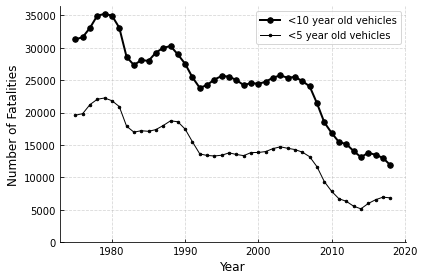

In [198]:
fig, ax = plt.subplots()

plt.plot(fatals_by_mod_10.index, fatals_by_mod_10.values,
         marker='.', ms=11, ls='-', c='black',
         lw=2, label='<10 year old vehicles')
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
ax.set_ylabel('Number of Fatalities')
ax.set_xlabel('Year')
ax.set_ylim(0)

plt.savefig(fig_out / "fatals_by_mod_year_10_less.png", dpi=360)

plt.plot(fatals_by_mod_5.index, fatals_by_mod_5.values,
         marker='.', ms=5, ls='-', c='black',
         lw=1, label='<5 year old vehicles')

ax.legend()
plt.savefig(fig_out / "fatals_by_mod_year_10_5_less.png", dpi=360)


plt.show()

## Proportion of people involved in crashes who die

In [210]:
#fatals_per_year
people_per_year = people.query("VEH_NO != 0").groupby("YEAR")['PER_ID'].nunique()
males_per_year = people.query("VEH_NO != 0 and SEX == 'Male'").groupby("YEAR")['PER_ID'].nunique()
females_per_year = people.query("VEH_NO != 0 and SEX == 'Female'").groupby("YEAR")['PER_ID'].nunique()
dr_people_per_year = people.query("VEH_NO != 0 and PER_TYP=='Driver'").groupby("YEAR")['PER_ID'].nunique()
dr_males_per_year = people.query("VEH_NO != 0 and SEX == 'Male' and PER_TYP=='Driver'").groupby("YEAR")['PER_ID'].nunique()
dr_females_per_year = people.query("VEH_NO != 0 and SEX == 'Female' and PER_TYP=='Driver'").groupby("YEAR")['PER_ID'].nunique()
#male_fatals/people_per_year

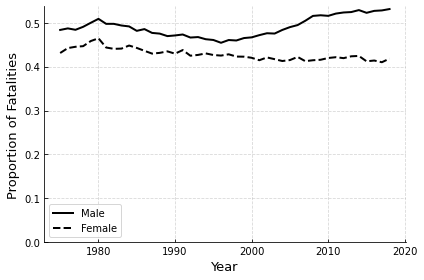

In [212]:
fig, ax = plt.subplots()
years = fatals_per_year.index
all_fatals = fatals_per_year.values
males_only = male_fatals.values/males_per_year.values
females_only = female_fatals.values/females_per_year.values
all_people = people_per_year.values
"""plt.plot(years, all_fatals/all_people,
         marker='', ms=5, ls='-', c='black', 
         lw=3, label='Total Fraction')"""
plt.plot(years, males_only,
         marker='', ms=5, ls='-', c='black',
         lw=2, label='Male')
plt.plot(years, females_only,
         marker='', ms=5, ls='--', c='black',
         lw=2, label='Female')
ax.set_ylabel('Proportion of Fatalities', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.legend()
ax.set_ylim(0)
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "prop_fatals_by_sex.png", dpi=360)
plt.show()

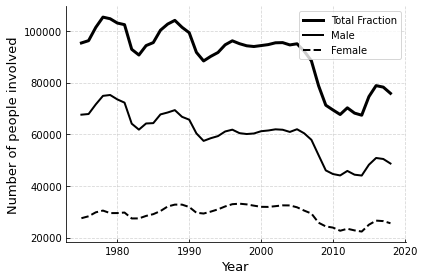

In [204]:
fig, ax = plt.subplots()
plt.plot(years, all_people,
         marker='', ms=5, ls='-', c='black', 
         lw=3, label='Total Fraction')
plt.plot(years, males_per_year.values,
         marker='', ms=5, ls='-', c='black',
         lw=2, label='Male')
plt.plot(years, females_per_year.values,
         marker='', ms=5, ls='--', c='black',
         lw=2, label='Female')
ax.set_ylabel('Number of people involved', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "people_in_crashes_by_sex.png", dpi=360)
plt.show()

## Relative to 1975

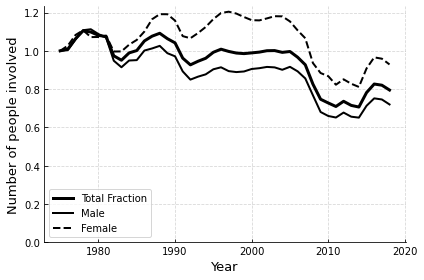

In [205]:
fig, ax = plt.subplots()
plt.plot(years, all_people/all_people[0],
         marker='', ms=5, ls='-', c='black', 
         lw=3, label='Total Fraction')
plt.plot(years, males_per_year.values/males_per_year.values[0],
         marker='', ms=5, ls='-', c='black',
         lw=2, label='Male')
plt.plot(years, females_per_year.values/females_per_year.values[0],
         marker='', ms=5, ls='--', c='black',
         lw=2, label='Female')
ax.set_ylabel('Number of people involved', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.legend()
ax.set_ylim(0)
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "people_in_crashes_comp75.png", dpi=360)
plt.show()

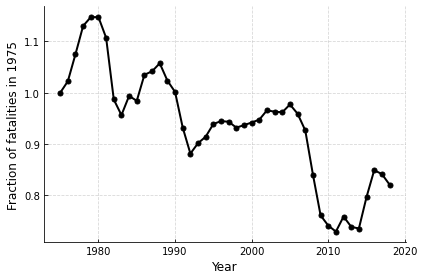

In [206]:
fig, ax = plt.subplots()
plt.plot(fatals_per_year.index, fatals_per_year.values/fatals_per_year.values[0],
         marker='o', ms=5, ls='-', c='black', 
         #alpha=0.5,
         lw=2, label='Total')
"""plt.plot(male_fatals.index, male_fatals.values/male_fatals.values[0],
         marker='', ms=5, ls='-', c='black',
         lw=1.5, label='Male')
plt.plot(female_fatals.index, female_fatals.values/female_fatals.values[0],
         marker='', ms=5, ls='--', c='black',
         lw=1.5, label='Female')
"""
ax.set_ylabel('Fraction of fatalities in 1975')
ax.set_xlabel('Year')
#ax.set_ylim(0)

#ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatals_comp75.png", dpi=360)
plt.show()

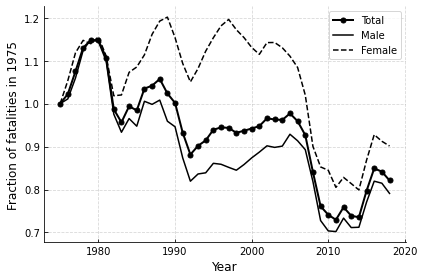

In [207]:
fig, ax = plt.subplots()
plt.plot(fatals_per_year.index, fatals_per_year.values/fatals_per_year.values[0],
         marker='o', ms=5, ls='-', c='black', 
         #alpha=0.5,
         lw=2, label='Total')
plt.plot(male_fatals.index, male_fatals.values/male_fatals.values[0],
         marker='', ms=5, ls='-', c='black',
         lw=1.5, label='Male')
plt.plot(female_fatals.index, female_fatals.values/female_fatals.values[0],
         marker='', ms=5, ls='--', c='black',
         lw=1.5, label='Female')

ax.set_ylabel('Fraction of fatalities in 1975')
ax.set_xlabel('Year')
#ax.set_ylim(0)

ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatals_by_sex_comp75.png", dpi=360)
plt.show()

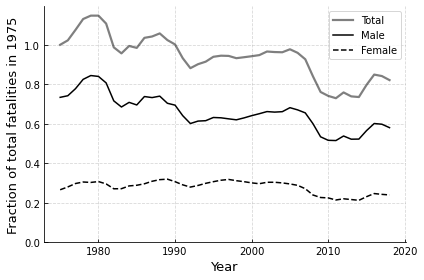

In [208]:
fig, ax = plt.subplots()
plt.plot(fatals_per_year.index, fatals_per_year.values/fatals_per_year.values[0],
         marker='', ms=5, ls='-', c='black', 
         alpha=.5,
         lw=2.2, label='Total')
plt.plot(male_fatals.index, male_fatals.values/fatals_per_year.values[0],
         marker='', ms=5, ls='-', c='black',
         lw=1.5, label='Male')
plt.plot(female_fatals.index, female_fatals.values/fatals_per_year.values[0],
         marker='', ms=5, ls='--', c='black',
         lw=1.5, label='Female')
ax.set_ylabel('Fraction of total fatalities in 1975', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylim(0)

ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatals_by_sex_comp75_2.png", dpi=360)
plt.show()

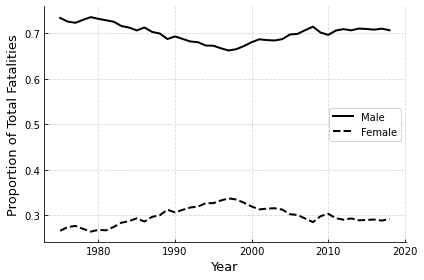

In [9]:
fig, ax = plt.subplots()
years = fatals_per_year.index
all_fatals = fatals_per_year.values
males_only = male_fatals.values/all_fatals
females_only = female_fatals.values/all_fatals
plt.plot(years, males_only,
         marker='', ms=5, ls='-', c='black',
         lw=2, label='Male')
plt.plot(years, females_only,
         marker='', ms=5, ls='--', c='black',
         lw=2, label='Female')
ax.set_ylabel('Proportion of Total Fatalities', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "prop_total_fatals_by_sex.png", dpi=360)
plt.show()

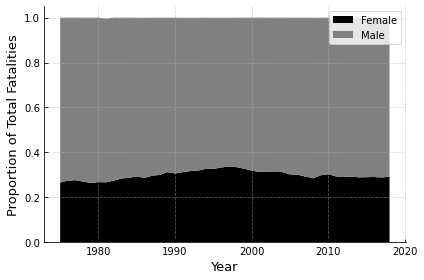

In [24]:
fig, ax = plt.subplots()
years = fatals_per_year.index
all_fatals = fatals_per_year.values
males_only = male_fatals.values/all_fatals
females_only = female_fatals.values/all_fatals
plt.stackplot(years,
              [females_only, males_only],
              labels=['Female', 'Male'],
              colors=['black', 'gray'])
ax.set_ylabel('Proportion of Total Fatalities', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "prop_total_fatals_by_sex_bar.png")
plt.show()

## Fatalities by model year

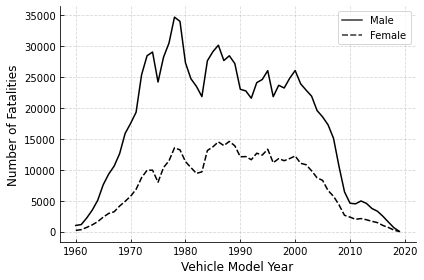

In [196]:
import seaborn as sns
cur_fatals = people_plus_mod_year.query("INJ_SEV == 'Fatal Injury (K)' & MOD_YEAR < 9000")
fatals_by_modyr = (cur_fatals.groupby(['MOD_YEAR', 'SEX'])['PER_ID']
                   .nunique()
                   .reset_index()
                   .query("SEX == 'Male' or SEX == 'Female'")
                   .query("9000 > MOD_YEAR >= 1960"))

fig, ax = plt.subplots()
g = sns.lineplot(x='MOD_YEAR', y='PER_ID',
                 data=fatals_by_modyr, #hue='SEX',
                 dashes=True, style='SEX',
                 style_order=['Male', 'Female'],
                 color='black',
                 #ci='sd',
                 #err_style='band',
                 ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_ylabel('Number of Fatalities')
ax.set_xlabel('Vehicle Model Year')


fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_out / "fatalities_per_model_year.png")
plt.show()

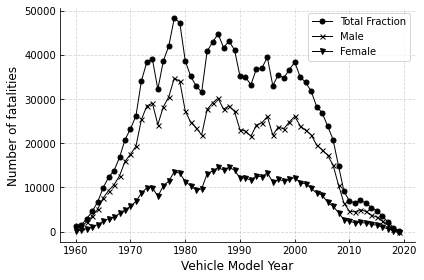

In [197]:
fatals_by_modyr = (cur_fatals
                   #.reset_index()
#                   .query("SEX == 'Male' or SEX == 'Female'")
                   .query("2020 > MOD_YEAR >= 1960")
                   .groupby(['MOD_YEAR', 'SEX'])['PER_ID'].nunique())
males_modyr = fatals_by_modyr.xs('Male', level='SEX').values
females_modyr = fatals_by_modyr.xs('Female', level='SEX').values
all_by_modyr = fatals_by_modyr.droplevel('SEX').groupby('MOD_YEAR').sum()

fig, ax = plt.subplots()
years = all_by_modyr.index

plt.plot(years, all_by_modyr.values,
         marker='o', ms=5, ls='-', c='black', 
         lw=1, label='Total Fraction')
plt.plot(years, males_modyr,
         marker='x', ms=5, ls='-', c='black',
         lw=1, label='Male')
plt.plot(years, females_modyr,
         marker='v', ms=5, ls='-', c='black',
         lw=1, label='Female')
ax.set_ylabel('Number of fatalities')
ax.set_xlabel('Vehicle Model Year')
ax.legend()
fig_out = Path(module_path) / "reports" / "figures" / "supplemental"
fig_out.mkdir(parents=True, exist_ok=True)
#plt.savefig(fig_out / "people_in_crashes_by_sex.png", dpi=360)
plt.show()

## Difference in GVWR by sex

In [31]:
per_vehmass = pd.merge(people.query("SEX == 'Male' or SEX == 'Female'"), vehicles[['YEAR', 'ST_CASE', 'MOD_YEAR', 'VEH_NO',
                                         'VIN_WGT']],
                                    on=['YEAR', 'ST_CASE', 'VEH_NO'], how='left', validate='m:1')

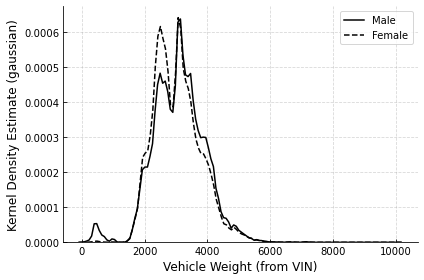

In [60]:
per_vehmass = per_vehmass.query("0 < VIN_WGT < 9999 and PERSON_TYPE == 'Driver'")
ax = sns.kdeplot(per_vehmass.query("SEX == 'Male'")['VIN_WGT'], label='Male',
                 kernel='gau',
                 linestyle = '-', color='black')
ax = sns.kdeplot(per_vehmass.query("SEX == 'Female'")['VIN_WGT'], label = 'Female',
                 kernel='gau',
                 linestyle = '--', color='black')
ax.set_xlabel('Vehicle Weight (from VIN)')
ax.set_ylabel('Kernel Density Estimate (gaussian)')
plt.savefig(fig_out / "f_v_m_vehicle_weight.png", dpi=360)

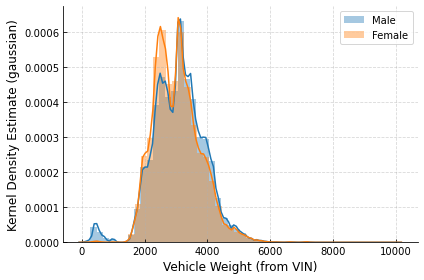

In [183]:
#per_vehmass = per_vehmass.query("0 < VIN_WGT < 9999 and PERSON_TYPE == 'Driver'")
#with sns.color_palette("gist_gray"):
ax = sns.distplot(per_vehmass.query("SEX == 'Male'")['VIN_WGT'], label='Male',
              kde=True, norm_hist=False)
ax = sns.distplot(per_vehmass.query("SEX == 'Female'")['VIN_WGT'], label = 'Female',
              kde=True, norm_hist=False)

ax.legend()
ax.set_xlabel('Vehicle Weight (from VIN)')
ax.set_ylabel('Kernel Density Estimate (gaussian)')
plt.savefig(fig_out / "f_v_m_vehicle_weight.png", dpi=360)

## Rural and Urban Crashes

In [73]:
per_acc = pd.merge(people.query("SEX == 'Male' or SEX == 'Female'"), 
                   accidents,
                    on=['YEAR', 'ST_CASE', 'STATE'], how='left', validate='m:1')

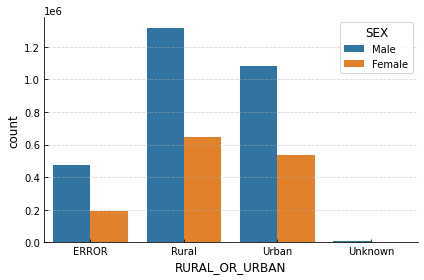

In [74]:
ax = sns.countplot(x="RURAL_OR_URBAN", data=per_acc,
                   hue='SEX')
#ax.set_xlabel('Vehicle Weight (from VIN)')
#ax.set_ylabel('Kernel Density Estimate (gaussian)')
#plt.savefig(fig_out / "f_v_m_vehicle_weight.png", dpi=360)

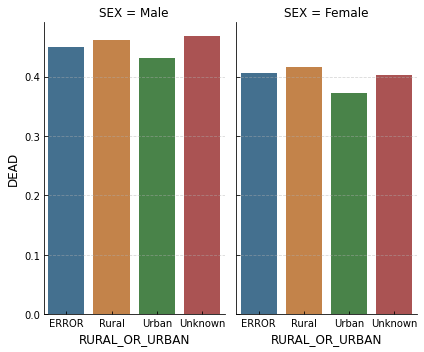

In [75]:
g = sns.catplot(x="RURAL_OR_URBAN", y="DEAD", col="SEX",
                data=per_acc, saturation=.5,
                kind="bar", ci=None, aspect=.6)

In [80]:
r_or_u = per_acc.query("RURAL_OR_URBAN == 'Rural' or RURAL_OR_URBAN == 'Urban' and PERSON_TYPE == 'Driver' or PERSON_TYPE == 'Passenger'")

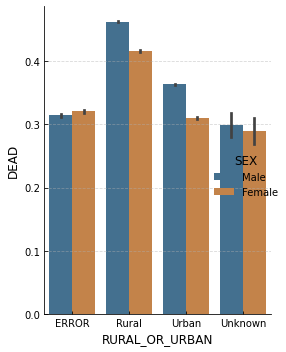

In [81]:
g = sns.catplot(x="RURAL_OR_URBAN", y="DEAD", hue="SEX",
                data=r_or_u, saturation=.5,
                kind="bar", aspect=.6)

## Distribution of passengers

In [124]:
per_veh = pd.merge(people.query("SEX == 'Male' or SEX == 'Female'"), 
                   vehicles,
                   on=['YEAR', 'ST_CASE', 'VEH_NO'], how='left', validate='m:1')

In [130]:
per_veh = per_veh.assign(No_Pass = lambda x: 0 * (x.NUMOCCS == 1) + 
                                             1 * (x.NUMOCCS == 2) + 
                                             2 * (x.NUMOCCS == 3) +
                                             3 * (x.NUMOCCS > 3))

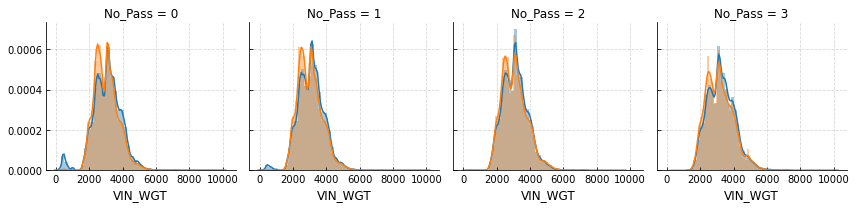

In [133]:
per_veh = per_veh.query("100 < VIN_WGT < 9999 and PERSON_TYPE == 'Driver'")
#with sns.color_palette("gist_gray"):
g = sns.FacetGrid(per_veh, col="No_Pass", hue='SEX')
g.map(sns.distplot, 'VIN_WGT')

#ax.legend()
#ax.set_xlabel('Vehicle Weight (from VIN)')
#ax.set_ylabel('Kernel Density Estimate (gaussian)')
#plt.savefig(fig_out / "f_v_m_vehicle_weight.png", dpi=360)

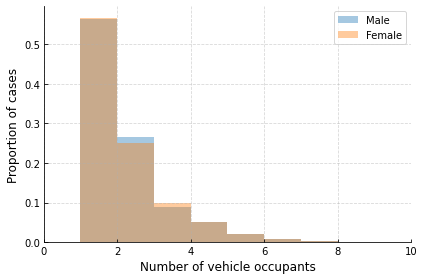

In [178]:
#g = sns.FacetGrid(per_veh.query("NUMOCCS < 10"), hue='SEX', legend_out=True)
#g.map(sns.distplot, 'NUMOCCS', hist=False)
ax = sns.distplot(per_veh.query("NUMOCCS < 99 and PERSON_TYPE == 'Driver' and SEX == 'Male'")['NUMOCCS'], label='Male',
                 kde=False, norm_hist=True,  bins=[0,1,2,3,4,5,6,7,8, 9, 10, 11])
ax = sns.distplot(per_veh.query("NUMOCCS < 99 and PERSON_TYPE == 'Driver' and SEX == 'Female'")['NUMOCCS'], label = 'Female',
                 kde=False, norm_hist=True, bins=[0,1,2,3,4,5,6,7,8, 9, 10, 11])
ax.set_xlabel('Number of vehicle occupants')
ax.set_ylabel('Proportion of cases')
ax.legend()
ax.set_xlim(0, 10)
plt.savefig(fig_out / "f_v_m_numoccs.png", dpi=360)
plt.show()

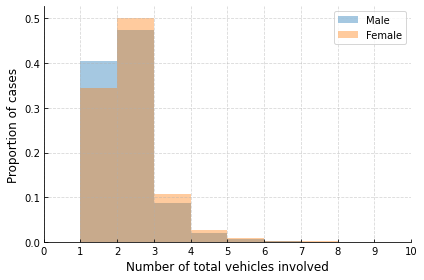

In [182]:
ax = sns.distplot(per_acc.query("VE_FORMS < 50 and PERSON_TYPE == 'Driver' and SEX == 'Male'")['VE_FORMS'], label='Male',
                 kde=False, norm_hist=True, bins=[0,1,2,3,4,5,6,7,8, 9, 10, 11])
ax = sns.distplot(per_acc.query("VE_FORMS < 50 and PERSON_TYPE == 'Driver' and SEX == 'Female'")['VE_FORMS'], label = 'Female',
                 kde=False, norm_hist=True, bins=[0,1,2,3,4,5,6,7,8, 9, 10, 11])
ax.set_xlabel('Number of total vehicles involved')
ax.set_ylabel('Proportion of cases')
ax.legend()
ax.set_xlim(0, 10)
ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.savefig(fig_out / "f_v_m_ve_inv.png", dpi=360)
plt.show()

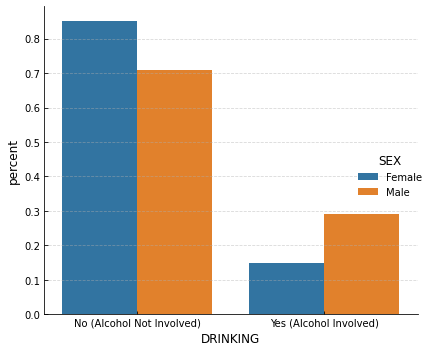

In [190]:
ax = (people
 .query("PERSON_TYPE == 'Driver'")
 .query("SEX == 'Male' or SEX == 'Female'")
 .query("DRINKING == 'Yes (Alcohol Involved)' or DRINKING == 'No (Alcohol Not Involved)'")
 .groupby('SEX')['DRINKING']
 .value_counts(normalize=True)
 .rename('percent')
 .reset_index()
 .pipe((sns.catplot,'data'), x='DRINKING', y='percent',hue='SEX', kind='bar'))

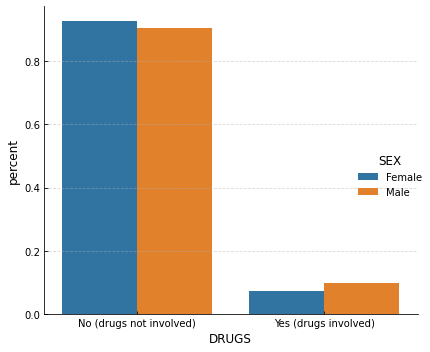

In [192]:
ax = (people
 .query("PERSON_TYPE == 'Driver'")
 .query("SEX == 'Male' or SEX == 'Female'")
 .query("DRUGS == 'Yes (drugs involved)' or DRUGS == 'No (drugs not involved)'")
 .groupby('SEX')['DRUGS']
 .value_counts(normalize=True)
 .rename('percent')
 .reset_index()
 .pipe((sns.catplot,'data'), x='DRUGS', y='percent',hue='SEX', kind='bar'))